In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
print(torch.cuda.is_available())

import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(42)

True


In [2]:
def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()     
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()     
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

In [3]:
def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

In [4]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 11, stride = 1, bias = False)
        # Define the activation function
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.pad(x, pad=(5,5,5,5), mode='circular')
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

In [5]:
# Load data
loaded_trajectory_pos = np.load('trajectory_pos.npy', allow_pickle=True)
N_STEPS = len(loaded_trajectory_pos)
NUM_PARTICLES = loaded_trajectory_pos[0].shape[0]
LX = 5. # BOX WIDTH
LY = 5.  # BOX HEIGHT
DEG_FREED = 2 # degrees of freedom, here x and y coordinates
N_FEATURES = NUM_PARTICLES * DEG_FREED
print('N_STEPS =', N_STEPS)
print('NUM_PARTICLES =', NUM_PARTICLES)
print('N_FEATURES =', N_FEATURES)

N_STEPS = 1001
NUM_PARTICLES = 12
N_FEATURES = 24


In [6]:
H = 50 # height of the image
W = 50 # width of the image (in cells)
frame = torch.zeros(N_STEPS, 1, H, W, dtype = torch.float32)
#In PyTorch, the standard format for an image tensor is [C, H, W]
print(frame.shape)
real_xy = H*loaded_trajectory_pos[1:N_STEPS,:,:]/LY - 0.5
real_xy.shape

torch.Size([1001, 1, 50, 50])


(1000, 12, 2)

In [7]:
for t in range(N_STEPS):
    for n in range(NUM_PARTICLES):
        width  = int(W*loaded_trajectory_pos[t,n,0]/LX)
        height = int(H*loaded_trajectory_pos[t,n,1]/LY)
        frame[t,0,height,width] = 1.0

frame[-1,:,:].sum()

tensor(12.)

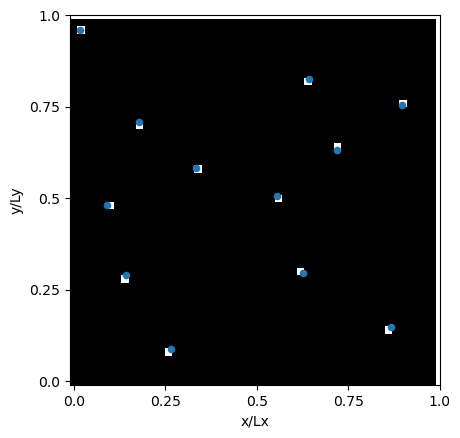

In [8]:
t=-1
plt.imshow(frame[t,0,:,:], cmap='gray', origin='lower')
plt.scatter(10.*loaded_trajectory_pos[t,:,0]-0.5, 10.*loaded_trajectory_pos[t,:,1]-0.5, marker='o', s=20)
num_ticks = 5
tick_positions = np.linspace(0, 50, num_ticks)
tick_labels = np.linspace(0, 1, num_ticks)
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)
plt.xlabel('x/Lx')
plt.ylabel('y/Ly') 
plt.show()

torch.Size([1001, 1, 50, 50])


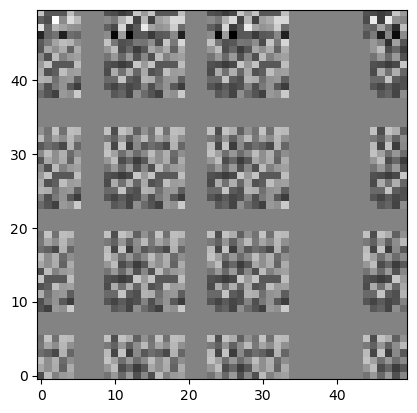

tensor([[0.4839, 0.5178, 0.4996,  ..., 0.5070, 0.4845, 0.5014],
        [0.5115, 0.5041, 0.5131,  ..., 0.4912, 0.4775, 0.4862],
        [0.5184, 0.5035, 0.5140,  ..., 0.5061, 0.4928, 0.5025],
        ...,
        [0.5310, 0.4910, 0.5158,  ..., 0.4937, 0.4729, 0.5188],
        [0.4891, 0.4833, 0.5397,  ..., 0.5338, 0.5042, 0.5010],
        [0.5204, 0.4864, 0.4864,  ..., 0.4813, 0.5219, 0.5076]])
max =  tensor(0.5601, grad_fn=<MaxBackward1>)
min =  tensor(0.4557, grad_fn=<MinBackward1>)


In [9]:
#just for fun
try_model = CNN_Model()
conv_frame = try_model(frame)
print(conv_frame.shape)
plt.imshow(conv_frame[0,0,:,:].detach(), cmap='gray', origin='lower')
plt.show()
print(conv_frame[0,0,:,:].detach())
print('max = ',conv_frame.max())
print('min = ',conv_frame.min())

In [10]:
x = frame[0:N_STEPS-1,:,:,:]
y = frame[1:N_STEPS,:,:,:]
print(x.shape)
print(y.shape)
print(np.array_equal(x[1],y[0]))#just to check that the shifted time steps are correct

torch.Size([1000, 1, 50, 50])
torch.Size([1000, 1, 50, 50])
True


In [11]:
# Data preparation

# Builds tensors from numpy arrays BEFORE split
x_tensor = x.detach()
y_tensor = y.detach()

# Builds dataset
dataset = TensorDataset(x_tensor, y_tensor)
# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

In [12]:
# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [13]:
# Training loop Configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN_Model()
model.to(device)
# Defines an optimizer to update the parameters  retrieved directly from the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Defines the loss function
loss_fn = nn.BCELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

In [14]:
#Training
n_epochs = 400
losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)  
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
    if epoch % (n_epochs//5) == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Val loss: {val_loss:.3f}")

Epoch: 0 | Train loss: 0.687 | Val loss: 0.680
Epoch: 80 | Train loss: 0.343 | Val loss: 0.342
Epoch: 160 | Train loss: 0.313 | Val loss: 0.313
Epoch: 240 | Train loss: 0.308 | Val loss: 0.308
Epoch: 320 | Train loss: 0.308 | Val loss: 0.308


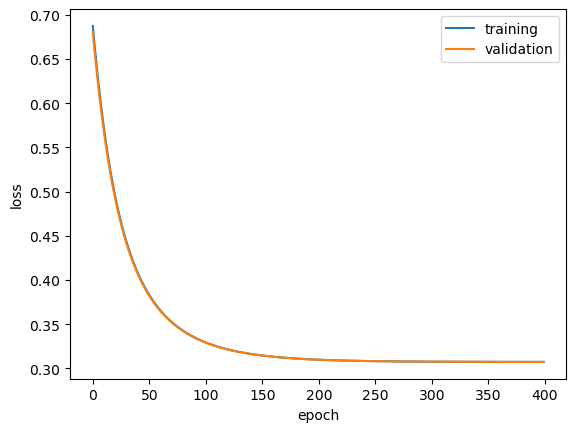

In [15]:
plt.plot(losses, label = 'training')
plt.plot(val_losses, label = 'validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

torch.Size([1000, 1, 50, 50])


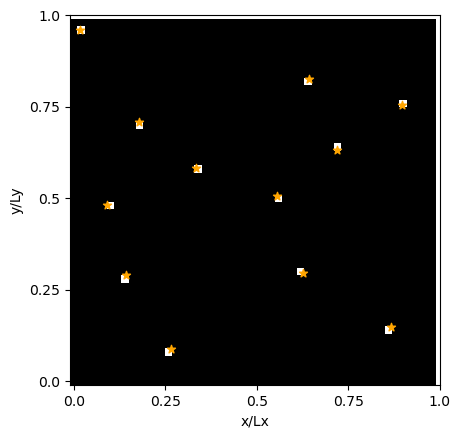

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
max =  tensor(0.9231, device='cuda:0')
min =  tensor(5.1927e-13, device='cuda:0')


In [22]:
model.eval()
with torch.inference_mode(): predicted_t = model(x.to(device))
print(predicted_t.shape)
time = -1
plot_frame = predicted_t[time,0,:,:].detach().cpu()
plot_frame = plot_frame.round()
plt.scatter(real_xy[time,:,0], real_xy[time,:,1], marker='*', color='orange')
plt.imshow(plot_frame, cmap='gray', origin='lower')
num_ticks = 5
tick_positions = np.linspace(0, 50, num_ticks)
tick_labels = np.linspace(0, 1, num_ticks)
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)
plt.xlabel('x/Lx')
plt.ylabel('y/Ly') 
plt.show()
print(plot_frame)
print('max = ',predicted_t.max())
print('min = ',predicted_t.min())

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def make_video(real_y, predicted_t, file_name):
    # Update function for the animation
    def update(frame_number, real_y, predicted_t, scatter_pred, time_text, img_plot):
        # Update the scatter plot for the new frame
        scatter_pred.set_offsets(real_y[frame_number])
        # Update the image plot for the new frame
        plot_frame = predicted_t[frame_number, 0, :, :].detach().cpu()
        plot_frame = plot_frame.round()
        img_plot.set_data(plot_frame)
        # Update the time annotation
        time_text.set_text(f'Time = {frame_number}')
    
    # Set up the figure, the axis, and the plot elements we want to animate
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    num_ticks = 5
    tick_positions = np.linspace(0, 50, num_ticks)
    tick_labels = np.linspace(0, 1, num_ticks)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(tick_labels)
    ax.set_xlabel('x/Lx')
    ax.set_ylabel('y/Ly')

    # Create initial scatter plot and image plot
    scatter_pred = ax.scatter(real_y[0, :, 0], real_y[0, :, 1], color='orange', marker='*')
    img_plot = ax.imshow(predicted_t[0, 0, :, :].detach().cpu().round(), cmap='gray', origin='lower')
    time_text = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center')

    # Create the animation using FuncAnimation
    ani = FuncAnimation(fig, update, frames=len(real_y), fargs=(real_y, predicted_t, scatter_pred, time_text, img_plot), interval=100)

    # Save the animation
    ani.save(file_name, writer='ffmpeg')

    # Convert the animation to an HTML5 video embedded in the notebook
    html = HTML(ani.to_html5_video())

    # Close the figure to prevent it from displaying in the notebook or script output
    plt.close(fig)

    # Return the HTML object to display the animation in the notebook
    return html

In [18]:
make_video(real_xy, predicted_t, 'comparison_video.mp4')

In [19]:
#fully predicted
fully_predicted_xy =  predicted_t.detach().clone().round()
model.eval()
for i in range(1, len(x)):
    with torch.inference_mode():
        fully_predicted_xy[i,:,:,:] = model(fully_predicted_xy[i-1,:,:,:].detach().clone()).cpu()

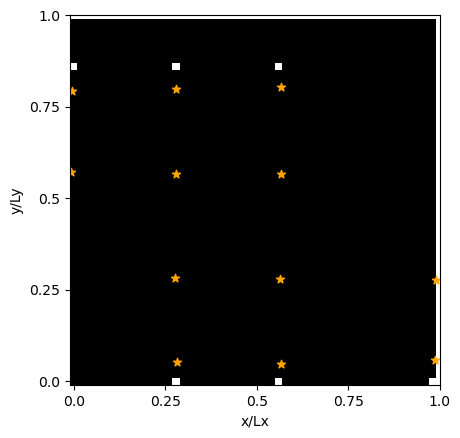

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
max =  tensor(1., device='cuda:0')
min =  tensor(0., device='cuda:0')


In [20]:
time = 10
new_plot_frame = fully_predicted_xy[time,0,:,:].detach().cpu()
new_plot_frame = new_plot_frame.round()
plt.scatter(real_xy[time,:,0], real_xy[time,:,1], marker='*', color='orange')
plt.imshow(new_plot_frame, cmap='gray', origin='lower')
num_ticks = 5
tick_positions = np.linspace(0, 50, num_ticks)
tick_labels = np.linspace(0, 1, num_ticks)
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)
plt.xlabel('x/Lx')
plt.ylabel('y/Ly') 
plt.show()
print(plot_frame)
print('max = ',fully_predicted_xy.max())
print('min = ',fully_predicted_xy.min())

some particles disappear. Here we lost the particle structure, we only have pictures with dots. In the moment things go wrong, mass in not conserved and dots can disappear. Before, at least, I had particles positions. The particle position can be very wrong, but the particle cannot disappear. The 'picture' idea and the convolutions satisfy the permutability condition, but not the (particle) conservation condition

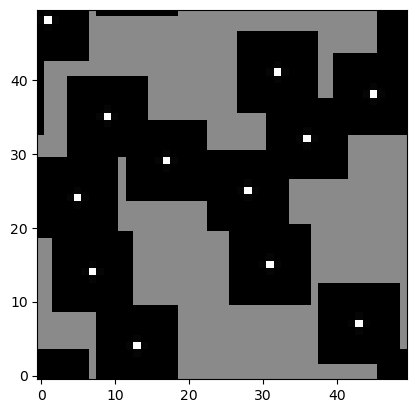

In [21]:
conv_frame = model(frame.to(device)).cpu()
plt.imshow(conv_frame[-1,0,:,:].detach(), cmap='gray', origin='lower')
plt.show()